# Data Science Component Building 
### time series analysis, classification of headlines,topic modelling and sentimenta analysis and predictive analysis and modelling among various global media agencies

This section aims to build various models for our data inorder to gain a deeper understanding. Using the insights we gained from the EDA, we create various pipelines.


## Tools

I'll be using the library like nltk, sklearn, gensim and various other libraries to facilitate in creating various models


In [1]:
# preparing and importing the necessary packages 
import pandas as pd
import numpy as np
import sys
import os
# Manually setting the correct path to src directory
sys.path.append("../../../OFFICAL WEEK0")

from src.loader import NewsDataLoader
import src.utils_ml as utils_ml
import src.utils as utils


In [2]:
# defining the appropriate path for each path
path = {
    "rating":"../../data/cleaned_rating.csv",
    "domains_location":os.environ['DOMAINS_LOCATION_PATH'],
    "traffic":"../../data/cleaned_traffic.csv"}

# initiating the newsdataloader class
data_loader = NewsDataLoader(path)

In [3]:
# importing relevant data by using the NewsDataloader class 
rating = data_loader.get_data("rating")

domains_location = data_loader.get_data("domains_location")

traffic = data_loader.get_data("traffic")

### For further analysis let's take in the data and clean it up for nltk

## Text cleaning

### Removing noise

we will be doing the following:
* Remove the stopwords.
* Make all the text lowercase.
* Remove punctuation.
* Normalizing the data by using lemmatization.

In [4]:
rating[["title","content"]] = rating[["title","content"]].map(utils_ml.pre_process)

once the data is cleaned we can use TfidfVectorizer and cosine similarity which is included in the "extract_similarity" function which recieves two columns and sets the similarity among them in the third column 

In [5]:
utils_ml.extract_similarity(rating,"title","content","title_content_similarity")

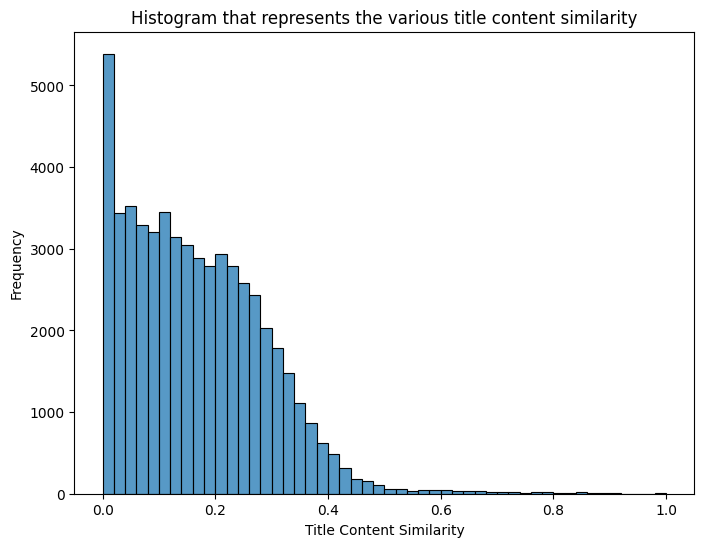

In [6]:
utils.histogram(rating,rating["title_content_similarity"],"Histogram that represents the various title content similarity","Title Content Similarity","Frequency",figsize=(8,6),bins=50)

the histogram shows that there is not much similarity between the content and title

next for further analysis let's add the keywords to each column

In [7]:
top_features = utils_ml.key_word_extractor(rating["content"])

In [8]:
top_features

,top_keywords
0,"[london, pavyllon, lane, hotel, park, season, ..."
1,"[nice, hicham, clermont, boudaoui, lowly, seco..."
2,"[amphibian, salamander, newt, frog, 2579, stud..."
3,"[sediment, redorange, ironrich, betsiboka, 756..."
4,"[sayi, 3913, existential, streamer, lineup, ma..."
...,...
54578,"[troublesthe, shivakumar, 2527, karnataka, wro..."
54579,"[fc, barcelona, mundo, 7676, deportivo, europa..."
54580,"[david, story, lubarskys, lubarsky, unsung, fe..."
54581,"[farm, kerbers, bringing, village, west, 4513,..."


In [9]:
rating.reset_index(drop=True, inplace=True)
top_features.reset_index(drop=True, inplace=True)
rating = pd.concat([rating, top_features], axis=1)

In [10]:
topics = {
    "Breaking News": ["breaking", "news", "update", "latest", "developing"],
    "Politics": ["politics", "government", "election", "candidate", "party"],
    "World News": ["world", "global", "international", "foreign", "diplomacy"],
    "Business/Finance": ["business", "finance", "economy", "market", "stock"],
    "Technology": ["tech", "technology", "innovation", "gadget", "startup"],
    "Science": ["science", "research", "study", "experiment", "discovery"],
    "Health": ["health", "medicine", "wellness", "fitness", "disease"],
    "Entertainment": ["entertainment", "movie", "tv", "music", "celebrity"],
    "Sports": ["sports", "game", "team", "player", "championship"],
    "Environment": ["environment", "climate", "sustainability", "green", "eco"],
    "Crime": ["crime", "justice", "law", "police", "investigation"],
    "Education": ["education", "school", "university", "learning", "teacher"],
    "Weather": ["weather", "forecast", "climate", "storm", "hurricane"],
    "Other": ["misc", "general", "random", "unknown", "unclassified"]
}

For categorizing the text to the above topics let's use both the title and the extracted keywords

In [11]:

title_tag = pd.DataFrame(utils_ml.categorize_headlines(rating['title'], topics),columns=["title_tag"])

keyword_tag = pd.DataFrame(utils_ml.categorize_headlines(rating['top_keywords'].apply(lambda x:" ".join(x)), topics),columns=["keyword_tag"])

title_tag.reset_index(drop=True, inplace=True)
keyword_tag.reset_index(drop=True, inplace=True)

# let's combine it to fill columns with other tags so that it could be more descriptive
title_keyword_merged = pd.concat([title_tag, keyword_tag], axis=1)

In [12]:
title_keyword_merged.reset_index(drop=True, inplace=True)
keyword_tag.reset_index(drop=True, inplace=True)

# let's combine it to fill columns with other tags so that it could be more descriptive
title_keyword_merged = pd.concat([title_tag, keyword_tag], axis=1)

In [13]:
title_keyword_merged

,title_tag,keyword_tag
0,Other,Other
1,Other,Environment
2,World News,Other
3,Other,Other
4,Other,Other
...,...,...
54578,Politics,Other
54579,Other,Other
54580,Other,Other
54581,Other,Other


In [14]:
title_keyword_merged

,title_tag,keyword_tag
0,Other,Other
1,Other,Environment
2,World News,Other
3,Other,Other
4,Other,Other
...,...,...
54578,Politics,Other
54579,Other,Other
54580,Other,Other
54581,Other,Other


In [15]:
def combine_values(val1, val2):
    
    if val1 == 'Other':
        if val2 == "Other":
            return "Other"
        else:
            return val2
    else:
        if val2 == "Other":
            return val1
        elif val1 == val2 :
            return val1
        else:
            val1 = [x.strip() for x in val1.split(",")]
            val2 = [x.strip() for x in val2.split(",")]
            valcombined = val1+val2
            return ", ".join(list(set(valcombined)))
title_keyword_merged_result = title_keyword_merged.apply(lambda row: combine_values(*[row["title_tag"], row["keyword_tag"]]),axis=1)

In [16]:
title_keyword_merged_result.reset_index(drop=True, inplace=True)
rating.reset_index(drop=True, inplace=True)

# let's combine it to fill columns with other tags so that it could be more descriptive
rating = pd.concat([rating, title_keyword_merged_result], axis=1)

In [17]:
# converting the names inorder to make easier for later
rating_names = {0:"categories_known"}
rating.rename(columns=rating_names,inplace=True)

### Topic Modeling

There are three ways to appraoch topic modeling, the first is using tfidfvectorizer with TruncatedSVD, the second is using an lda model lastly we will use bertopic

Let's try both appraoches and check if there are similarities between the topics generated

#### First Approach : Using TfIdf Vectorizer with Truncated SVD

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

topic_tfidf = TfidfVectorizer(stop_words="english", max_features= 1000, max_df = 0.5, smooth_idf=True)
topic_vector = topic_tfidf.fit_transform(rating["title"]+" "+ rating["content"])
topic_vector_array= topic_vector.toarray()
svd_model = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=100, random_state=122)
svd_model.fit(topic_vector_array)
topic_vector_array_reduced = svd_model.transform(topic_vector_array)

terms = topic_tfidf.get_feature_names_out()
topics = []

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    topics.append("Topic "+str(i)+": ")
    for t in sorted_terms:
        topics.append(t[0])

final_topic_list = [topics[i:i+8] for i in range(0, len(topics), 8)]

for x in final_topic_list:
    print (x)

['Topic 0: ', 'report', 'share', 'free', 'llc', 'quarter', 'according', 'recent']
['Topic 1: ', 'market', '2023', 'nov', 'globe', 'newswire', 'global', 'billion']
['Topic 2: ', 'traded', 'rating', 'price', 'report', 'stock', 'share', 'stocknewscom']
['Topic 3: ', 'market', 'rating', 'research', 'report', 'stocknewscom', 'billion', 'usd']
['Topic 4: ', 'traded', 'stock', 'trading', 'high', 'low', 'share', 'market']
['Topic 5: ', 'earnings', 'result', 'november', 'quarterly', 'dividend', '2023', 'company']
['Topic 6: ', 'gaza', 'israel', 'hamas', 'israeli', 'war', 'palestinian', 'stock']
['Topic 7: ', 'short', 'october', 'target', '31st', 'totalling', 'month', 'price']
['Topic 8: ', 'stock', 'share', 'sold', 'transaction', 'stocknewscom', 'rating', 'november']
['Topic 9: ', 'india', 'world', 'earnings', 'market', 'cup', 'quarterly', 'dividend']


In [19]:

utils_ml.topic_modelling_tfidf(rating["title"],max_features=1000, max_df = 0.5,n_components=10,n_iter=100,random_state=122)

{'Topic 0': ['inc', 'share', 'stock', 'llc', 'holding', 'management', 'co'],
 'Topic 1': ['market', 'stock', 'billion', 'price', 'usd', 'cagr', 'global'],
 'Topic 2': ['share', 'market', 'billion', 'sell', 'usd', 'cagr', 'global'],
 'Topic 3': ['price', 'new', 'target', 'share', 'group', 'analyst', 'given'],
 'Topic 4': ['new', '2023', 'result', 'investment', 'llc', 'quarter', 'say'],
 'Topic 5': ['2023',
  'result',
  'financial',
  'quarter',
  'inc',
  'earnings',
  'third'],
 'Topic 6': ['inc', 'new', 'group', 'sell', 'analyst', 'interest', 'set'],
 'Topic 7': ['gaza', 'israel', 'say', 'war', 'hamas', 'stock', 'attack'],
 'Topic 8': ['stock', 'new', 'sell', 'share', 'co', 'update', 'insider'],
 'Topic 9': ['group',
  'stocknewscom',
  'rating',
  'buy',
  'coverage',
  'co',
  'analyst']}

Second Approach is to use LDA for topic modelling and assign which documents belong to which topic

we'll vectorize and then create and apply the LDA model. Detailed funcion implementatin is shown in the utils_ml file

In [20]:
lda_model,model_output,vectorizer,topics = utils_ml.topic_modelling_lda(rating['title'],10)

In [21]:
# displaying the topics
topics

{'Topic 0': ['future',
  'industry',
  'limited',
  'rating',
  'international',
  'day',
  'set',
  'target',
  '2023',
  'report'],
 'Topic 1': ['analyst',
  'earnings',
  'new',
  'llc',
  'company',
  'price',
  'investment',
  'group',
  'share',
  'inc'],
 'Topic 2': ['action',
  'hold',
  '2032',
  'research',
  'plan',
  'cut',
  'update',
  'trust',
  'cagr',
  'market'],
 'Topic 3': ['llc',
  'short',
  'interest',
  'growth',
  'ukraine',
  'corp',
  'stock',
  'capital',
  'position',
  'management'],
 'Topic 4': ['wealth',
  'asset',
  'service',
  'advisor',
  'financial',
  'buy',
  'llc',
  'million',
  'sell',
  'stock'],
 'Topic 5': ['trading',
  'system',
  'black',
  'make',
  'best',
  'dividend',
  'size',
  'deal',
  'inc',
  'holding'],
 'Topic 6': ['amid',
  'coverage',
  'top',
  'war',
  'stocknewscom',
  'usd',
  'india',
  'israel',
  'say',
  'gaza'],
 'Topic 7': ['show',
  'watch',
  'canada',
  '2023',
  '2024',
  'release',
  'first',
  'result',
  'rea

In [22]:
topicnames = ["Topic " + str(i) for i in range(10)]
docnames = ["Document " + str(i) for i in range(len(rating['title']))]

df_document_topic = pd.DataFrame(np.round(model_output, 2), columns=topicnames, index=docnames)
main_topic = np.argmax(df_document_topic.values, axis=1)

rating['main_topic'] = main_topic

In [38]:
rating.groupby['main_topic'].count()

54583

c:\Users\alaza\OneDrive\Desktop\Offical Week0\notebooks\ML\../../../OFFICAL WEEK0\src\utils.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  sns_plot.set_xticklabels(sns_plot.get_xticklabels(), rotation=45, horizontalalignment="right")


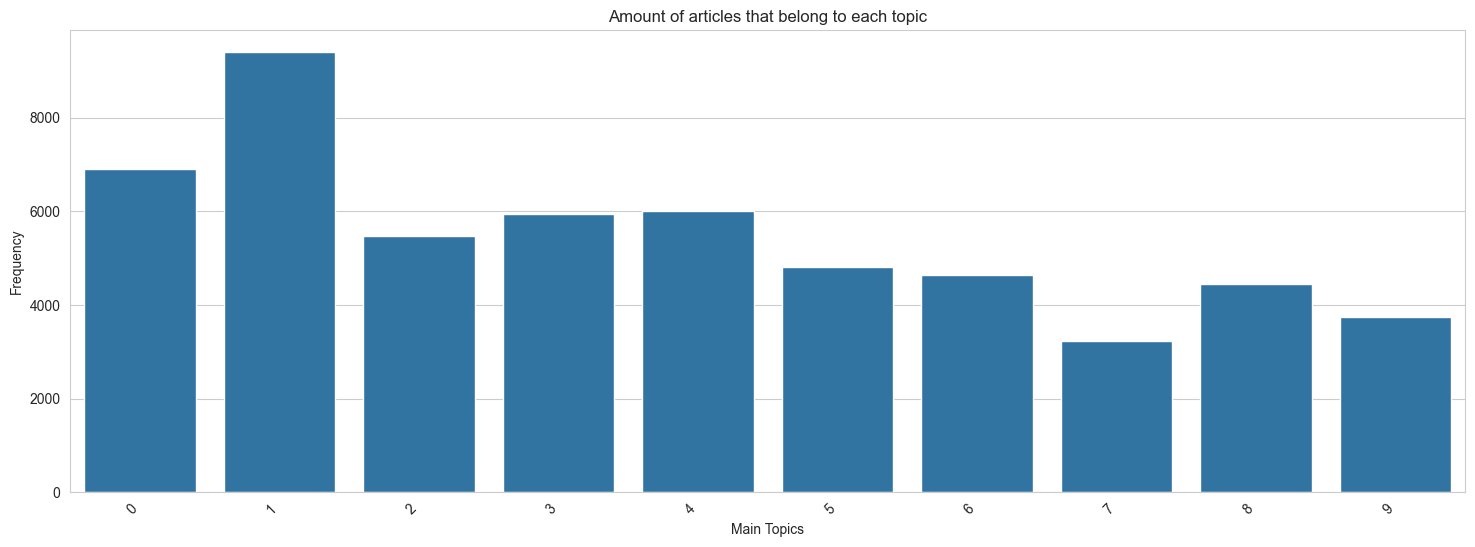

In [39]:
grouped_main_topic = rating.groupby("main_topic")["article_id"].count()
utils.barchart(x_axis=grouped_main_topic.index,y_axis=grouped_main_topic.values,x_label="Main Topics",y_label="Frequency",title="Amount of articles that belong to each topic",orientation="vertical")

[6902 9392 5468 5951 6006 4808 4644 3220 4439 3753]
Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64', name='main_topic')


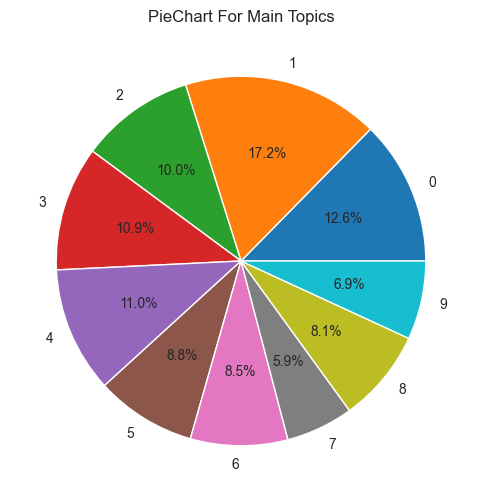

In [24]:
utils.pie_chart(title="PieChart For Main Topics",count=grouped_main_topic.values,labels=grouped_main_topic.index)
# utils.barchart(x_axis=grouped_main_topic.index,y_axis=grouped_main_topic.values,x_label="Main Topics",y_label="Frequency",title="Amount of articles that belong to each topic",orientation="vertical")